### Exploratory Notebook Trying to Get MHD Orzang Tang looking nice... 


In [1]:

import sys
sys.path.append("../../")
import os

os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"
os.environ["JAX_PLATFORMS"] = "cuda"  # or: os.environ["JAX_PLATFORM_NAME"]="cuda"
#using GPU, comment out if on CPU?
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '2'
import jax
jax.config.update("jax_disable_jit", False)

jax.config.update("jax_debug_nans", True)
print(jax.lib.xla_bridge.get_backend().platform_version)  # sanity: shows CUDA/cuDNN


/tmp/ipykernel_59228/4082734232.py:15: DeprecationWarning: jax.lib.xla_bridge.get_backend is deprecated; use jax.extend.backend.get_backend.
  print(jax.lib.xla_bridge.get_backend().platform_version)  # sanity: shows CUDA/cuDNN


PJRT C API
cuda 12030


In [2]:
def side_by_side(mine,athenas,title):
    fig,ax = plt.subplots(1,2,figsize=(7,4),sharey=True)
    vmin,vmax = athenas.min(),athenas.max()
    ax[0].imshow(mine,vmin=vmin,vmax=vmax)
    ax[1].imshow(athenas,vmin=vmin,vmax=vmax)
    plt.show()

In [4]:
#load athena ICs (not used in this version)
import h5py
import jax.numpy as jnp
from diffhydro.utils.io import athinput,athdf

#athena_outputs_loc = "/home/ben.horowitz/DiffHydro_public/sims/ot/"
#ic_filename = "OrszagTang.out2.00000.athdf"
#ICs = athdf(athena_outputs_loc+ic_filename)


In [32]:
import diffhydro as dh


eq = dh.equationmanager_mhd.EquationManagerMHD()
eq.mesh_shape=[256,256,1]

In [52]:
def orszag_tang_2d(eq, embed_in_3d: bool = True):
    # use eq.mesh_shape and optional eq.box_size
    import jax.numpy as jnp

    nx, ny = eq.mesh_shape[0], eq.mesh_shape[1]
    nz = eq.mesh_shape[2] if (len(eq.mesh_shape) > 2) else 1
    box_size = getattr(eq, "box_size", (2.0 * jnp.pi, 2.0 * jnp.pi, 1.0))
    Lx, Ly = float(box_size[0]), float(box_size[1])

    x = (jnp.arange(nx) + 0.5) * (Lx / nx)
    y = (jnp.arange(ny) + 0.5) * (Ly / ny)
    X, Y = jnp.meshgrid(x, y, indexing="ij")

    rho0 = 25.0 / (36.0 * jnp.pi)
    p0   =  5.0 / (12.0 * jnp.pi)

    rho = jnp.ones((nx, ny)) * rho0
    u   = -jnp.sin(Y); v = jnp.sin(X); w = jnp.zeros_like(u)
    Bx  = -jnp.sin(2.0*Y); By = 0.5 * jnp.sin(4.0 * X); Bz = jnp.zeros_like(u)
    p   = jnp.ones_like(u) * p0

    W2 = jnp.stack([rho, u, v, w, Bx, By, Bz, p], axis=0)  # (8, nx, ny)

    W = jnp.repeat(W2[..., jnp.newaxis], nz, axis=-1) if embed_in_3d else W2
    U = eq.get_conservatives_from_primitives(W)

    # If you’re running GLM (n_cons==9), ensure ψ row exists/zeroed
    if getattr(eq, "n_cons", U.shape[0]) == 9 and U.shape[0] == 8:
        psi = jnp.zeros_like(U[0])
        U = jnp.vstack([U, psi[jnp.newaxis, ...]])

    t_final = 0.5
    return U, t_final

In [53]:
IC,_ = orszag_tang_2d(eq)

In [54]:
IC.shape

(8, 256, 256, 1)

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


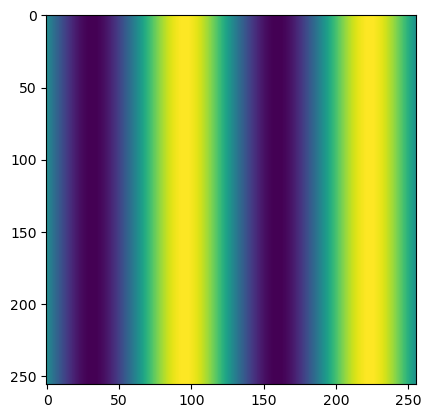

In [55]:
%pylab inline
imshow(IC[-4])

In [56]:
from diffhydro.solver.riemann_solver import RiemannSolver

In [57]:
eq.cfl

0.1

In [58]:
#start with basic HLL
ss = None #this isn't used in MHD 

#limiter seems to really matter for OT, use MC or minmod
#fancy things to try later
#ct = dh.mhd.ConstrainedTransportFlux(eq, solver, dh.MUSCL3(limiter="SUPERBEE"), positivity=False)
#ppct = dh.mhd.PPCTForce(eq, boundary=dh.NoBoundary,n_iter_max=1000)  # pass a boundary, it might work... untested


eq.cfl= 0.1
solver = dh.HLLD_MHD(equation_manager=eq,signal_speed=None)
cf = dh.ConvectiveFlux(eq,solver,dh.MUSCL3(limiter="MINMOD"),positivity=False)
#ct = dh.mhd.ConstrainedTransportFlux(eq, solver, dh.MUSCL3(limiter="MINMOD"), positivity=False)
ppct = dh.mhd.PPCTForce(eq, boundary=dh.NoBoundary,n_iter_max=1000)  # pass a boundary, it might work... untested

hydro = dh.hydro(n_super_step=4000, fluxes=[cf],forces=[],use_mol=True, use_ctu=False, integrator="SSPRK3") 

using CTU? False


In [59]:
params = {}
output = hydro.evolve(IC,params)

dt [Traced<ShapedArray(float32[])>with<DynamicJaxprTrace>]
using CTU? False
using CTU? False


In [60]:
field_out = output[0]
field_out_prim = eq.get_primitives_from_conservatives(field_out)

cf.timestep(output[0])

Array(0.01674016, dtype=float32)

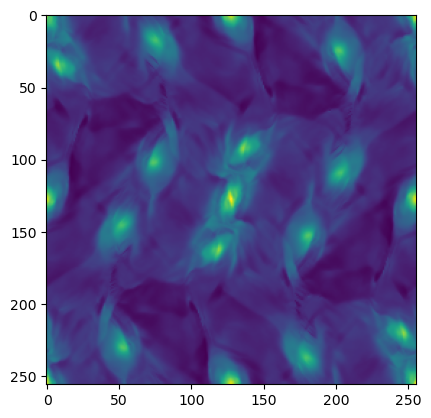

In [61]:
imshow(field_out_prim[0][:,:,0])

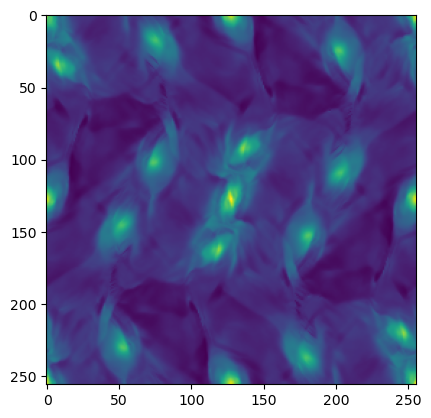

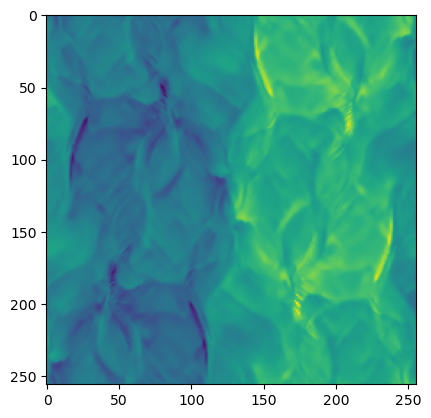

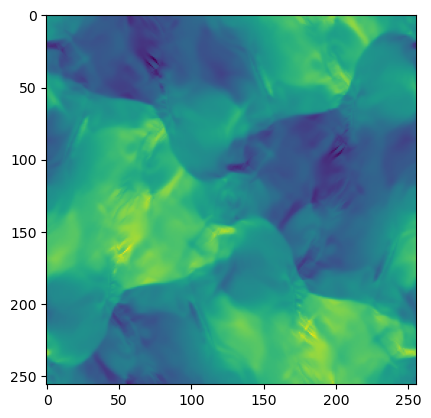

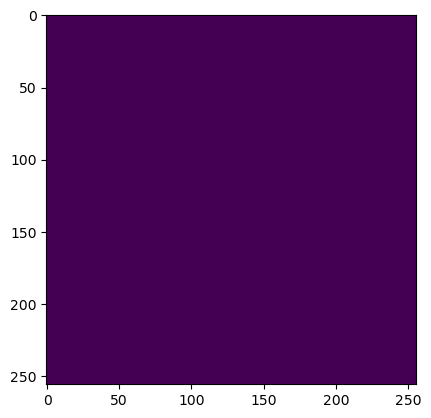

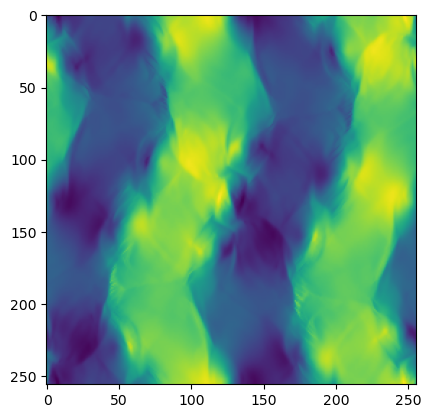

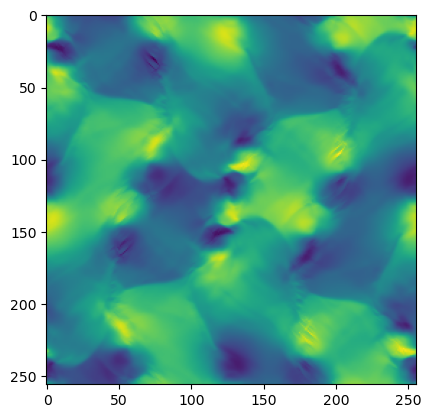

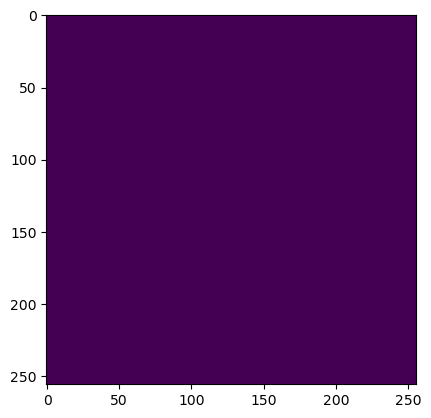

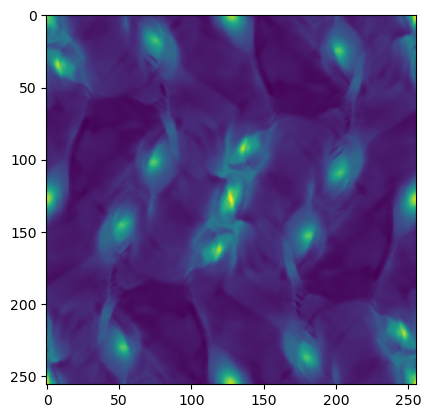

In [62]:

for i in range(0,8):
    imshow(field_out_prim[i][:,:,0])
    show()
    

In [43]:
hydro = dh.hydro(n_super_step=10000, fluxes=[cf],forces=[],use_mol=True, use_ctu=False, integrator="SSPRK3") 

using CTU? False


In [44]:
params = {}
output_noppct = hydro.evolve(IC,params)

dt [Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=1/0)>]
using CTU? False


In [45]:
field_out_prim_noppct = eq.get_primitives_from_conservatives(output_noppct[0])


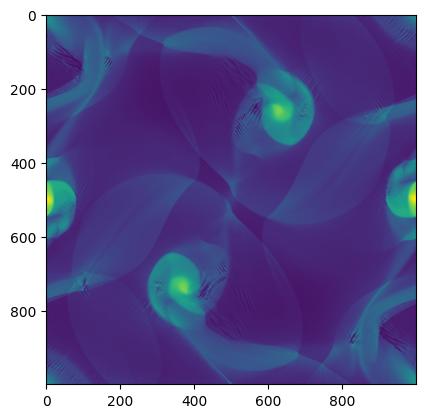

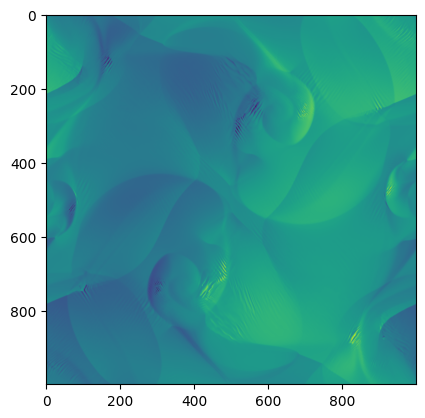

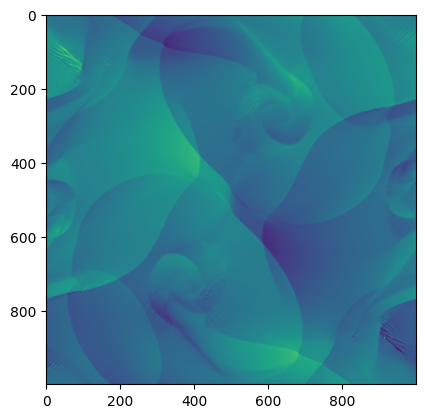

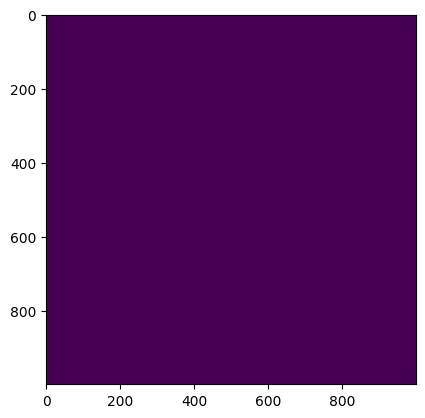

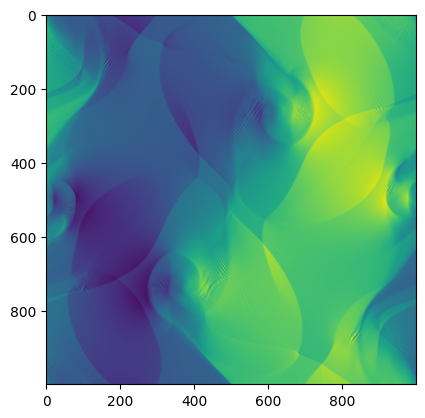

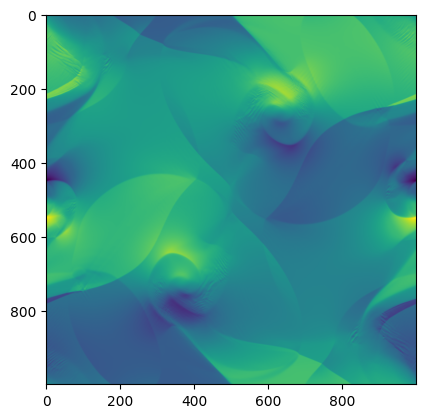

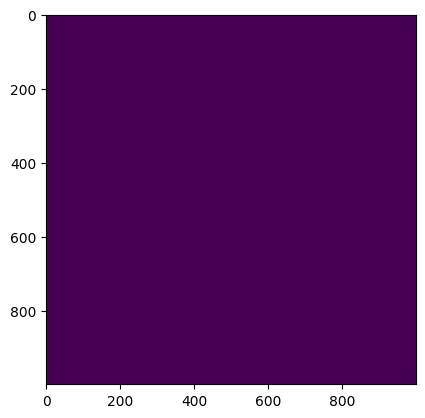

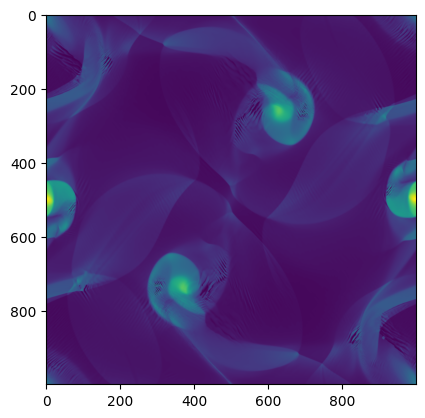

In [46]:

for i in range(0,8):
    imshow(field_out_prim_noppct[i][:,:,0])
    show()
    

In [47]:
#much slower...
hydro = dh.hydro(n_super_step=10000, fluxes=[cf],forces=[],use_mol=True, use_ctu=True, integrator="SSPRK3")
params = {}
output_ctu = hydro.evolve(IC,params)

using CTU? True
dt [Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=1/0)>]
using CTU? True
CTU
CTU


In [48]:
field_out_prim_ctu = eq.get_primitives_from_conservatives(output_ctu[0])


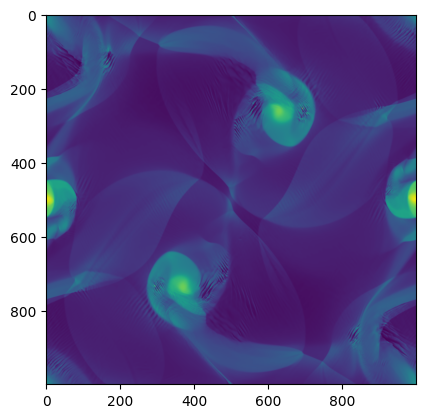

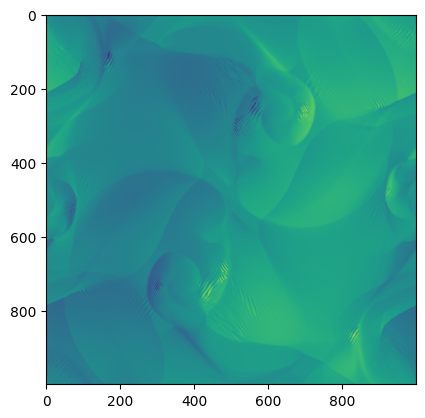

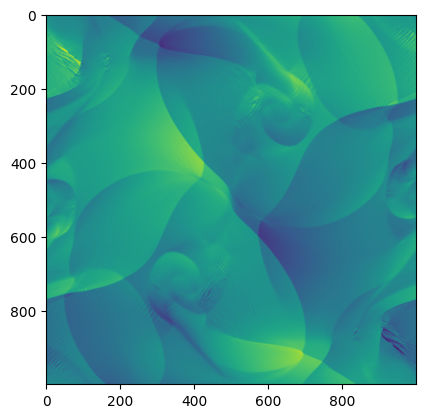

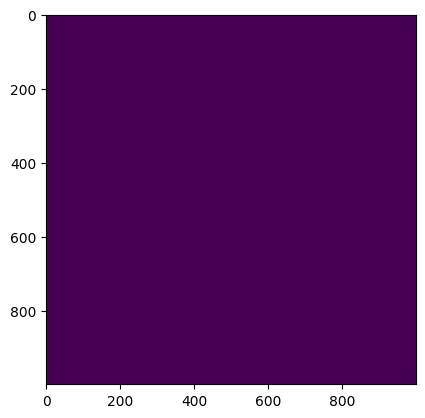

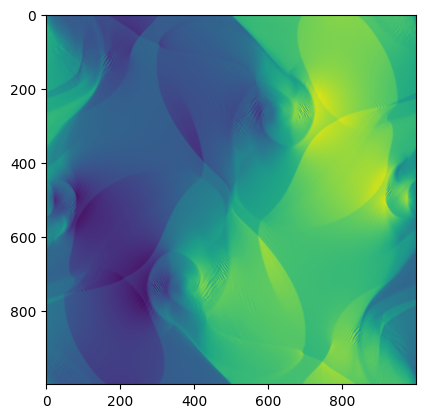

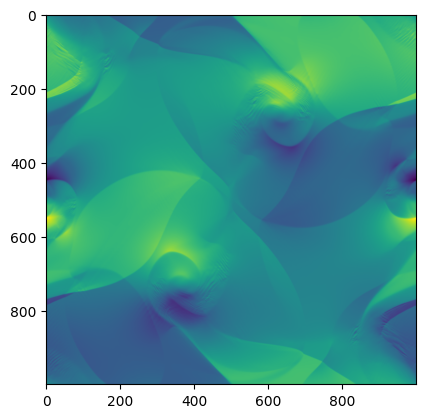

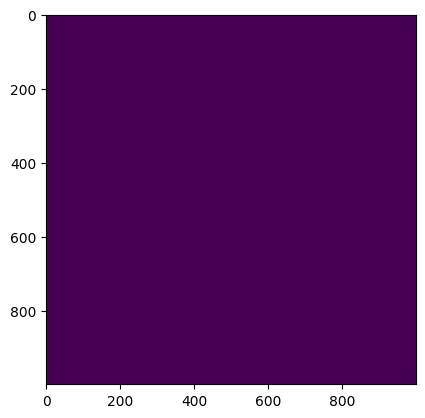

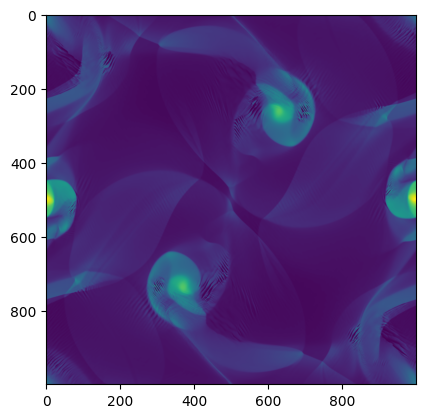

In [49]:

for i in range(0,8):
    imshow(field_out_prim_ctu[i][:,:,0])
    show()
    

In [50]:
#no better really... But CT isn't implemented...